In [1]:
import pandas as pd
import numpy as np
import re
import warnings
import string
warnings.filterwarnings('ignore')

import matplotlib.pylab as plt
import seaborn as sns

from tqdm import tqdm
from spellchecker import SpellChecker

import contractions
import nltk
from nltk.corpus import stopwords, wordnet
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
nltk.download('averaged_perceptron_tagger')

from collections import defaultdict, Counter

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fashaikh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\fashaikh\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
plt.rcParams['figure.figsize'] = [18, 15]
plt.style.use('fivethirtyeight')

In [3]:
sns.set(rc={'figure.figsize':(18, 15)})
sns.set_theme(style="darkgrid")

In [4]:
df_copy = pd.read_parquet(r"C:\Users\fashaikh\Desktop\Thesis_main\combined_emotion_sentiment.parquet")

In [5]:
df_copy.drop_duplicates(subset=['id','category'], inplace=True)

EDA

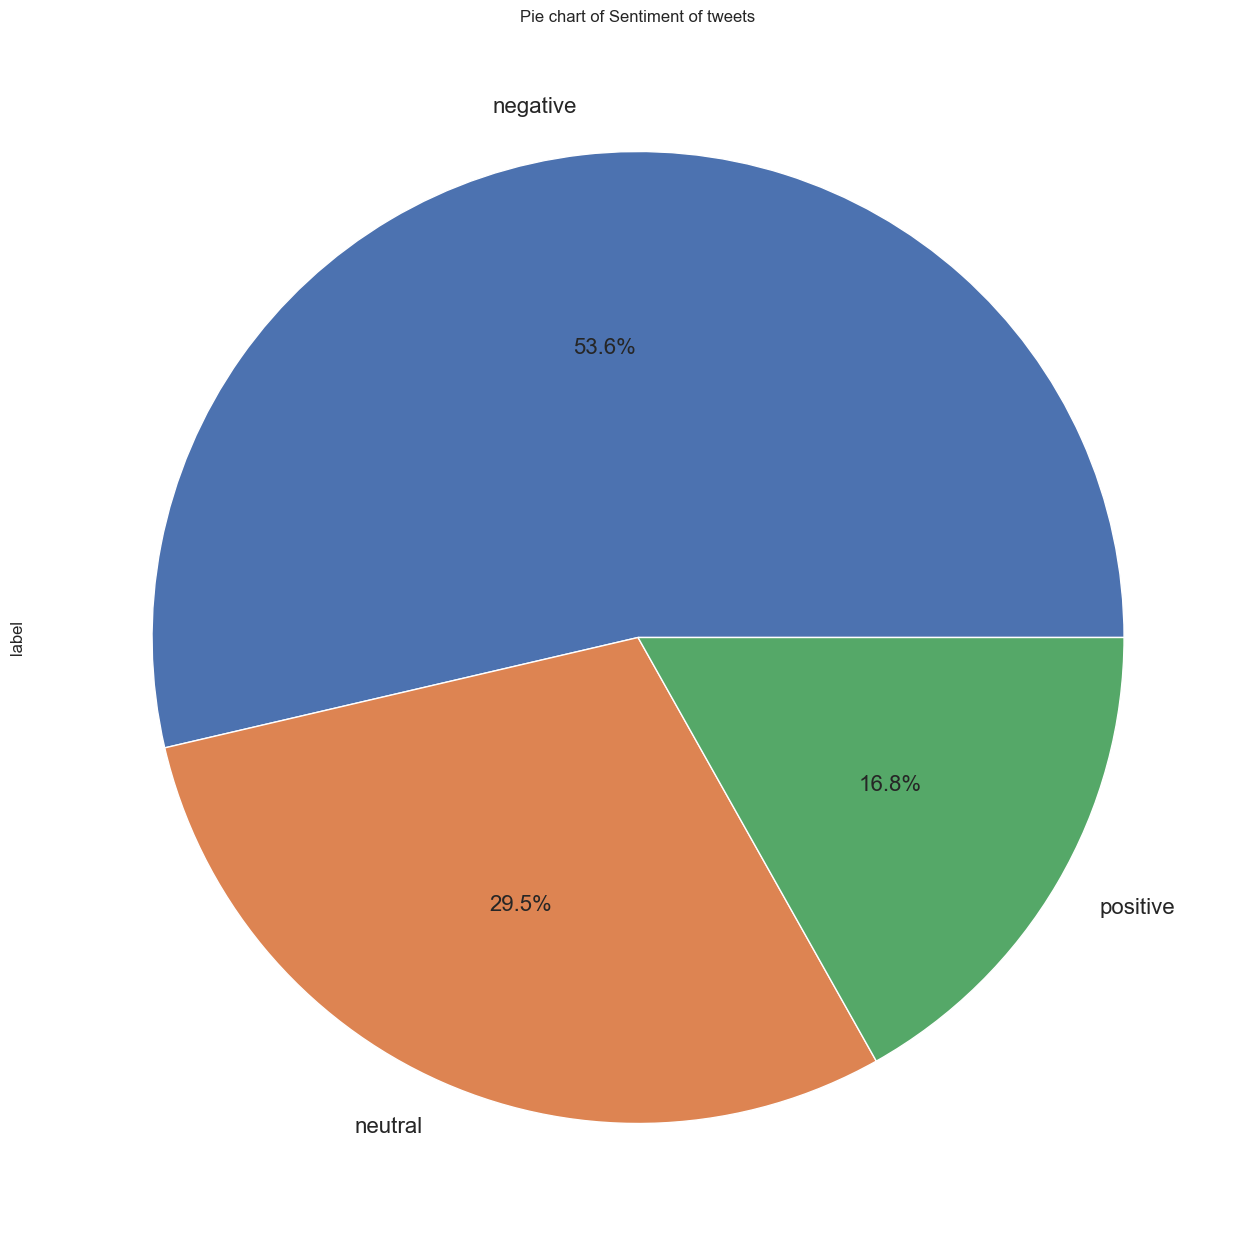

In [6]:
df_copy['label'].value_counts().plot(kind='pie',
                                         title='Pie chart of Sentiment of tweets', 
                                         autopct='%1.1f%%',
                                         shadow=False,
                                         legend = False, fontsize=16, figsize=(15,15))
plt.show()

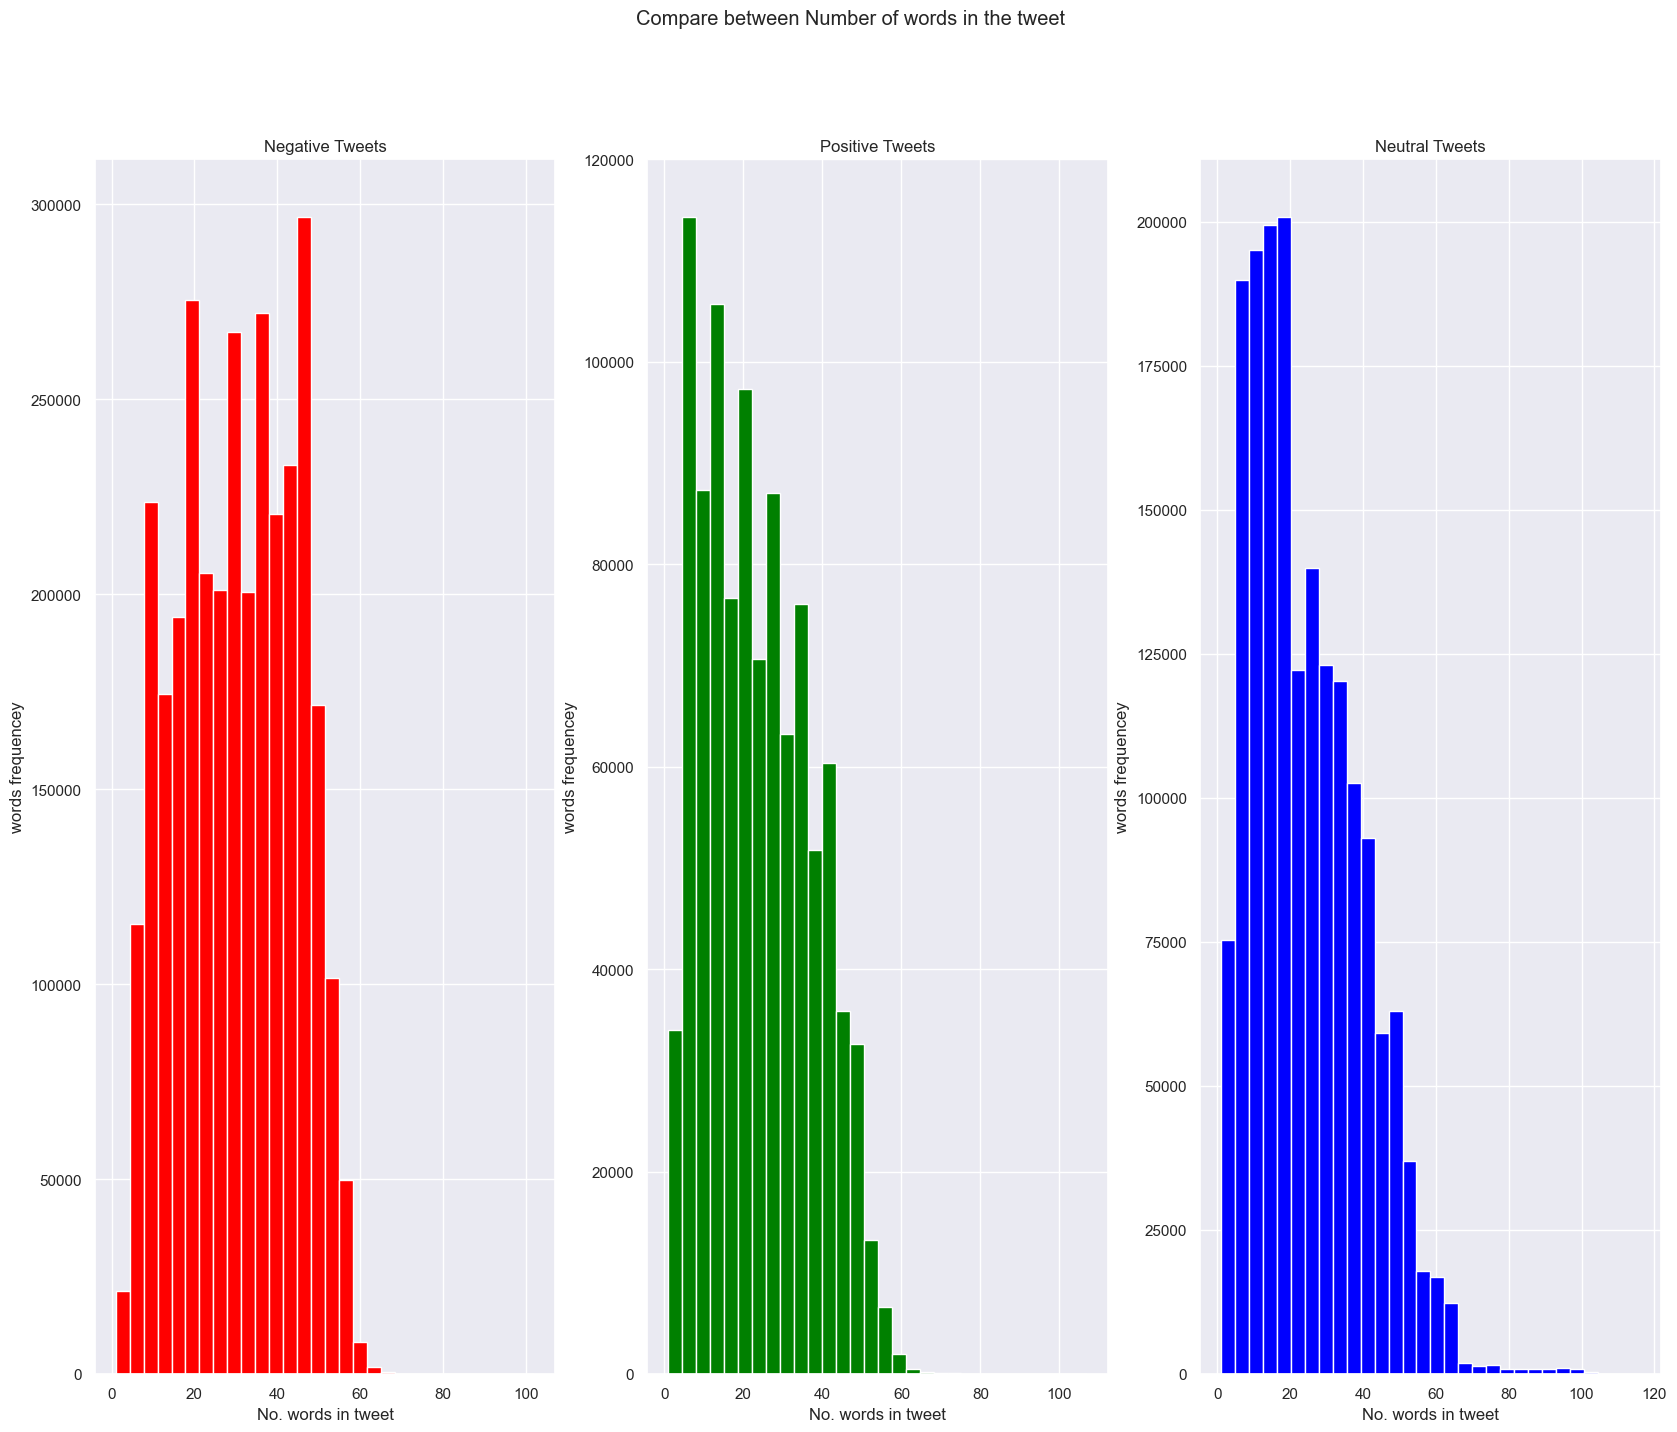

In [7]:
sns.set(style='darkgrid')
fig, axes = plt.subplots(1, 3)
fig.suptitle('Compare between Number of words in the tweet')

axes[0].hist(df_copy[df_copy['label'] == "negative"]['cleanedContent'].str.split().map(lambda word: len(word)),
             bins=30, color='red')
axes[0].set_ylabel('words frequencey')
axes[0].set_xlabel('No. words in tweet')
axes[0].set_title('Negative Tweets')


axes[1].hist(df_copy[df_copy['label'] == "positive"]['cleanedContent'].str.split().map(lambda word: len(word)),
             bins=30, color='green', label='Disaster')
axes[1].set_ylabel('words frequencey')
axes[1].set_xlabel('No. words in tweet')
axes[1].set_title('Positive Tweets')

axes[2].hist(df_copy[df_copy['label'] == "neutral"]['cleanedContent'].str.split().map(lambda word: len(word)),
             bins=30, color='blue', label='Disaster')
axes[2].set_ylabel('words frequencey')
axes[2].set_xlabel('No. words in tweet')
axes[2].set_title('Neutral Tweets')

plt.show()

Cleaning tweet

In [8]:
def clean_tweet(text):
    # Remove mentions
    text = re.sub(r"@user", "", text)

    # Remove URLs
    text = re.sub(r"http", "", text)

    # Remove extra whitespaces
    text = re.sub(r"\s+", " ", text).strip()

    # Remove leading whitespaces
    text = re.sub(r"^\s+","",text)

    # Replace &amp; with and
    text = re.sub(r"&amp;","and",text)

    return text

In [12]:
df_copy['text'] = df_copy['cleanedContent'].apply(clean_tweet)

Parse Hashtags

In [13]:
def parse_hashtags(text):
    hashtag=re.compile(r'(\#)(\w+)(_)(\w+)', re.IGNORECASE)
    text = hashtag.sub(r'\2 \4',text)
    return text.replace('_', ' ')

In [14]:
df_copy['text'] = df_copy['text'].apply(lambda sentence: parse_hashtags(sentence))

English contractions

In [15]:
def en_contractions(text):
    return ' '.join([contractions.fix(word)
                     if word in contractions.contractions_dict else word
                     for word in text.split()])

In [16]:
df_copy['text'] = df_copy['text'].apply(lambda sentence: en_contractions(sentence))

Remove special characters

In [17]:
s_chars = '¥₽ÏïŰŬĎŸæ₿₪ÚŇÀèÅ”ĜåŽÖéříÿý€ŝĤ₹áŜŮÂ₴ûÌÇšŘúüëÓ₫ŠčÎŤÆÒœ₩öËäøÍťìĈôàĥÝ¢ç“žðÙÊĉŭÈŒÐÉÔĵùÁů„âÄűĴóêĝÞîØòď฿ČÜþňÛ'
PUNC = '.+@«#_\-!$%%^&*¬()£<>?/\\|}\]\[{;\,~:\"\''

In [18]:
def special_char(text):
    # first, let's remove any unicode strings
    text = text.encode('ascii', 'ignore').decode()
    # remove printable bachslashes
    text = re.sub(r'[\t\s\n\r\b\a]', ' ', text)
    # Special letters
    text = re.sub(r'[{}]'.format(s_chars), '', text)
    # Punctuation
    text = re.sub(r'[{}]'.format(PUNC), ' ', text)
    # space at the start or the end of the context
    text = re.sub(r'(^\s)|(\s$)', '', text)
    # Single character
    text = re.sub(r'(\s[^iIaA]\s)', ' ', text)
    return text

In [19]:
df_copy['text'] = df_copy['text'].apply(lambda sentence: special_char(sentence))

Remove numbers

In [20]:
df_copy['text'] = df_copy['text'].str.replace('\d+', '', regex=True)

In [21]:
df_copy['text'] = df_copy['text'].str.replace("yr", 'year', regex=False)
df_copy['text'] = df_copy['text'].str.replace(r"\.|==|=|'|`|(PM)|(AM)|(UTC)", ' ', regex=True)
df_copy['text'] = df_copy['text'].str.replace("...", '', regex=False)
df_copy['text'] = df_copy['text'].str.replace(r"(\s[^iIaA]\s)", ' ', regex=True)
df_copy['text'] = df_copy['text'].str.replace(r'\s(\w$)|\s(\w[^me]$)', '', regex=True)
df_copy['text'] = df_copy['text'].str.replace(r'\s ', ' ', regex=True)
df_copy['text'] = df_copy['text'].str.replace(r'(^\s)|(\s$)', '', regex=True)

Stopwords Cleaning

In [22]:
SWs = set(stopwords.words("english"))

In [23]:
df_copy['text'] = df_copy['text'].str.lower()

In [24]:
def remove_stopwords(text):
    return " ".join([word for word in text.split()
                     if word not in SWs])

In [25]:
df_copy['text_without_stopwords'] = df_copy['text'].apply(lambda sentence: remove_stopwords(sentence))

Lemmatization

In [26]:
lemmatizer = WordNetLemmatizer()
wordnet_map = {'N': wordnet.NOUN, 'V': wordnet.VERB, 'J': wordnet.ADJ, 'R': wordnet.ADJ}
def adjusted_lemmatizer(text):
    # Split the snetence into words and each word with its type
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN))
                     for word, pos in pos_tagged_text])

In [27]:
df_copy['text_lemmatized'] = df_copy['text_without_stopwords'].apply(lambda sentence: adjusted_lemmatizer(sentence))

In [39]:
len(df_copy['text_lemmatized'].loc[
    df_copy['text_lemmatized'].str.contains(r"(\s[^iIaA]\s)")])

0

In [38]:
df_copy['text_lemmatized'] = df_copy['text_lemmatized'].str.replace(r"(\s[^iIaA]\s)", ' ', regex=True)
df_copy['text_lemmatized'] = df_copy['text_lemmatized'].str.replace(r'\s(\w$)|\s(\w[^me]$)', '', regex=True)
df_copy['text_lemmatized'] = df_copy['text_lemmatized'].str.replace(r'\s ', ' ', regex=True)
df_copy['text_lemmatized'] = df_copy['text_lemmatized'].str.replace(r'(^\s)|(\s$)', '', regex=True)

In [40]:
df_copy.to_parquet("lemmatized_new.parquet")

Frequent Words

In [31]:
def plot_words_freq(dataframe: pd.DataFrame,
                    column,
                    target_label, axes):
    words_dict = {'word': [], 'count': []}
    words_count = Counter(
        ' '.join(dataframe[[column,'label']]\
                 .loc[dataframe['label'] == target_label]\
                 [column]).split()).most_common(100)
    
    for word, count in words_count:
        words_dict['word'].append(word)
        words_dict['count'].append(count)
    
    sns.barplot(x=words_dict['count'][:20], y=words_dict['word'][:20], ax=axes)
    axes.set_yticks(range(20), words_dict['word'][:20], size=16)

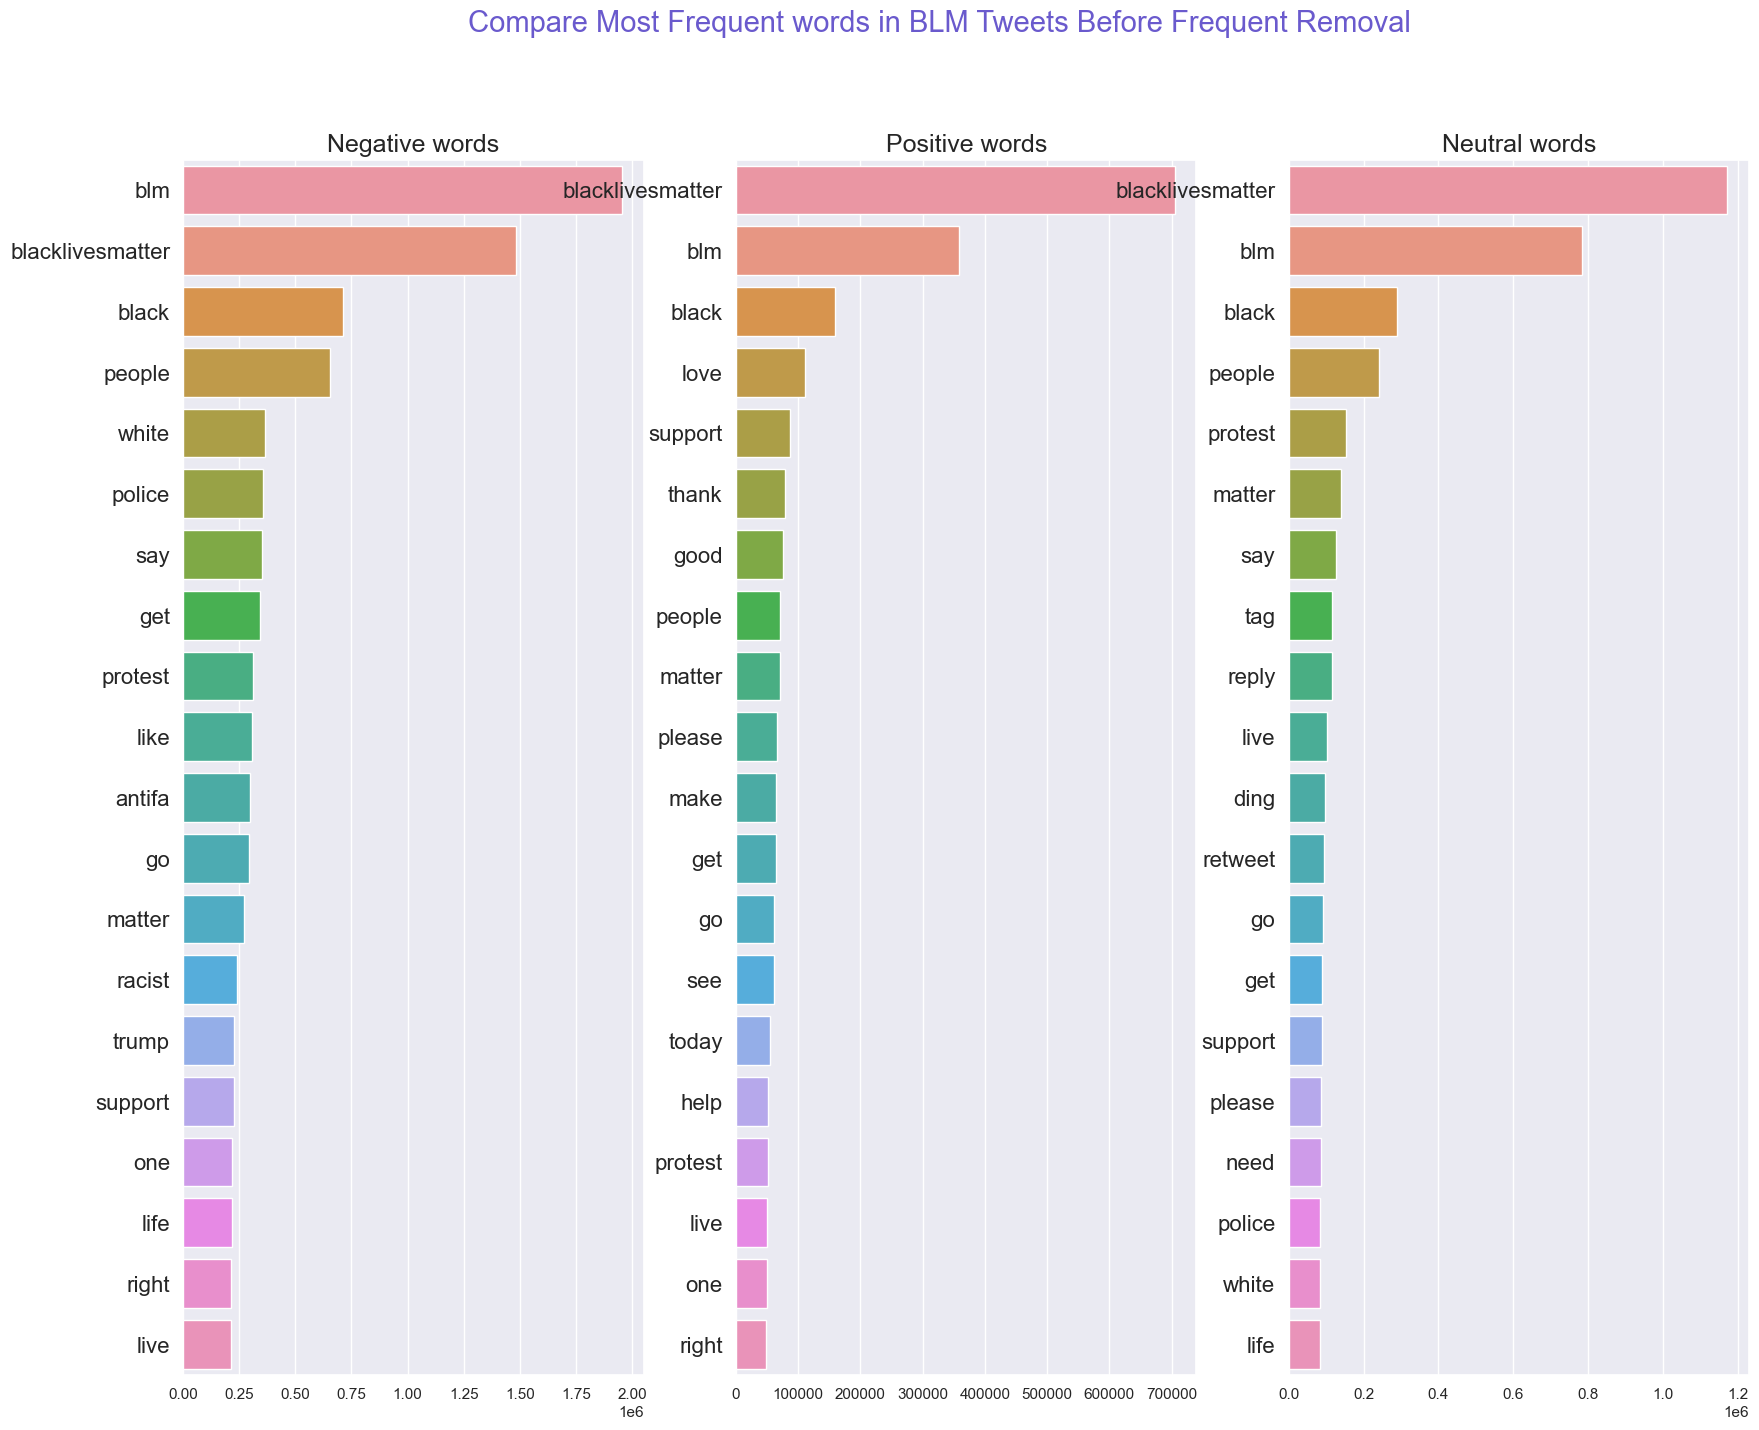

In [41]:
fig, axes = plt.subplots(1, 3)

fig.suptitle('Compare Most Frequent words in BLM Tweets Before Frequent Removal',
             size=21, color='SlateBlue')
axes[0].set_title('Negative words', size=18)
axes[1].set_title('Positive words', size=18)
axes[2].set_title('Neutral words', size=18)

plot_words_freq(df_copy, 'text_lemmatized', target_label="negative", axes=axes[0])
plot_words_freq(df_copy, 'text_lemmatized', target_label="positive", axes=axes[1])
plot_words_freq(df_copy, 'text_lemmatized', target_label="neutral", axes=axes[2])
plt.show()

In [42]:
NEGATIVE_WORDS = ['white', 'police', 'antifa', 'kill', 'racist', 'trump']
POSITIVE_WORDS = ['love', 'thank', 'good', 'please', 'today', 'right', 'help']

In [43]:
def words_counter_removal(dataframe: pd.DataFrame,
                          column,
                          frequency,
                          ascending: False):
    """
    | Select the topest/lowest frequent words to in a set.
    Args:
        dataframe[pd.DataFrame]: dataframe you're going to select the frequent words from.
        column[Text]: column you're going to select the frequent words from.
        frequency[int]: the number of words you're going to select from the list of tuples.
        ascending[Optional[bool]]: whether ascending | descending. (default: False)
    Returns:
        Set[Text]
    """
    counter = Counter()
    for tweet in dataframe[column].values:
        for word in tweet.split():
            counter[word] += 1
    
    # Words should not be detected
    for word in NEGATIVE_WORDS + POSITIVE_WORDS:
        counter.pop(word)
    
    if not ascending:
        return set([word for (word, counts) in counter.most_common(frequency)])
    else:
        return set([word for (word, counts) in counter.most_common()[:-frequency-1:-1]])

In [44]:
FREQ_WORDS = words_counter_removal(df_copy, 'text_lemmatized', 20, False)

In [45]:
def remove_freqwords(text,
                     freq_words):
    """custom function to remove the frequent words"""
    return " ".join([word for word in str(text).split() if word not in freq_words])

In [46]:
df_copy['text_without_stopwords_freq'] = df_copy['text_lemmatized'].apply(lambda text: remove_freqwords(text, FREQ_WORDS))

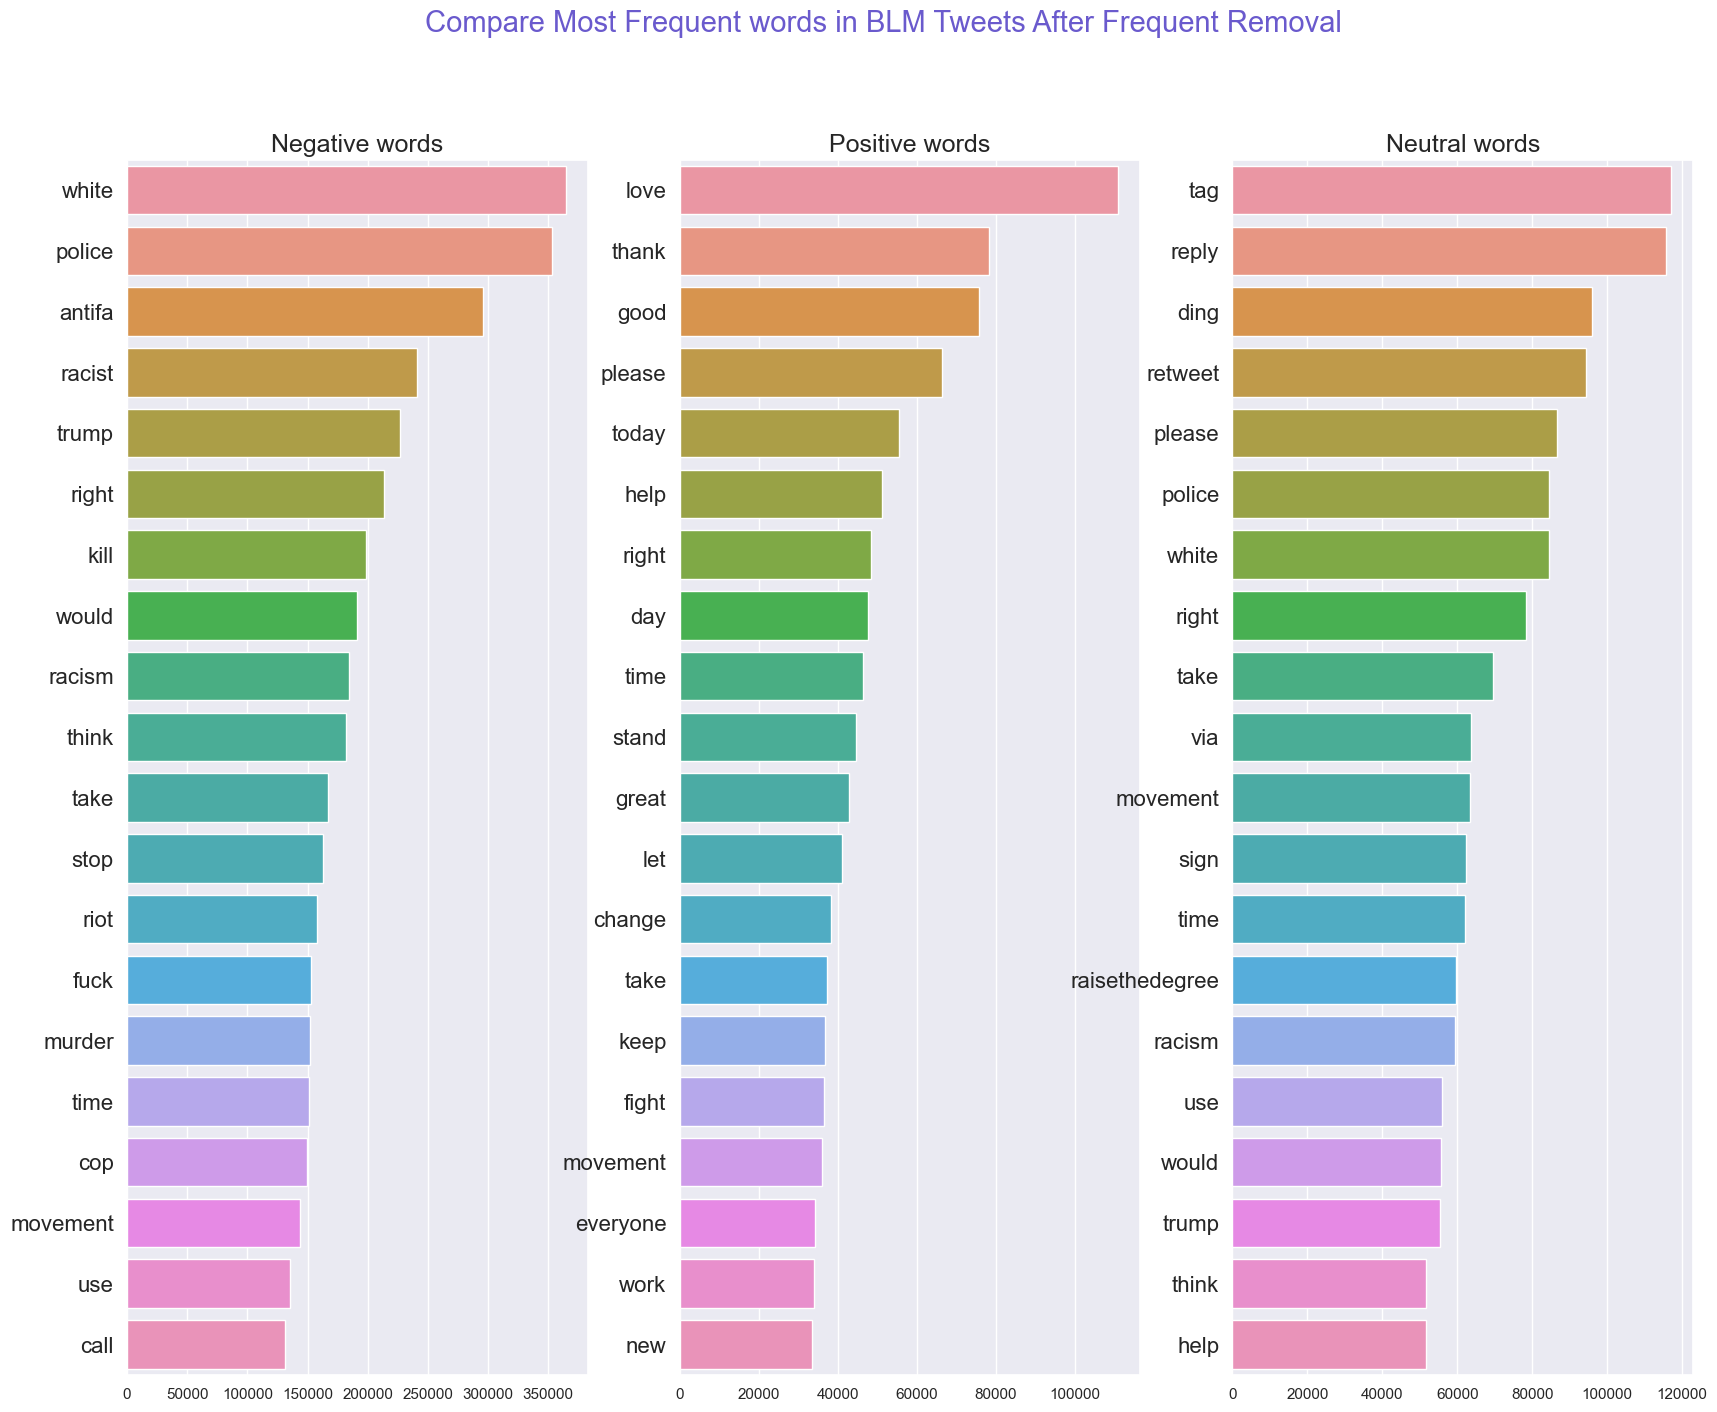

In [47]:
fig, axes = plt.subplots(1, 3)

fig.suptitle('Compare Most Frequent words in BLM Tweets After Frequent Removal',
             size=21, color='SlateBlue')
axes[0].set_title('Negative words', size=18)
axes[1].set_title('Positive words', size=18)
axes[2].set_title('Neutral words', size=18)

plot_words_freq(df_copy, 'text_without_stopwords_freq', target_label="negative", axes=axes[0])
plot_words_freq(df_copy, 'text_without_stopwords_freq', target_label="positive", axes=axes[1])
plot_words_freq(df_copy, 'text_without_stopwords_freq', target_label="neutral", axes=axes[2])
plt.show()

In [50]:
# Define the N-grams function
def gen_ngrams_fn(text, n_grams=2):
    # Split all the words and insert them into list in sequence;
    ## First, ensure that the word is not a `space`.
    ## Second, the word you're going to insert not inside the stopwords.
    word_list = [word for word in text.lower().split() 
                 if word != ' ']
    
    # capture N-sequence of words togther
    ngrams = zip(*[word_list[i:] for i in range(n_grams)])
    
    # Convert the context from list to str
    return [' '.join(ngram) for ngram in ngrams]

def ngrams_fn(dataframe,
              target_label,
              n_grams=2,
              sort=True):
    
    n_grams_dict = defaultdict(int)
    
    for tweet in dataframe[['text_without_stopwords_freq', 'label']]\
                     .loc[dataframe['label'] == target_label]['text_without_stopwords_freq']:
        for context in gen_ngrams_fn(tweet, n_grams):
            # Apply N-grams probability of the occurrence of certain N-words in certain Sequence
            # in form of most occurrence
            n_grams_dict[context] +=1
    
    # Create dataframe with number of occurrences is the id we sort the data with.
    n_grams_dataframe = pd.DataFrame(n_grams_dict.items())
    n_grams_dataframe.columns = ['N-grams', 'count']

    if sort:
        n_grams_dataframe.sort_values(by='count', ascending=False, inplace=True)
    
    return n_grams_dataframe


def plot_ngrams(dataframe,
                axes,
                number_of_samples=20) -> None:
    # Plot the dataset
    sns.barplot(x=dataframe.iloc[:,1][:number_of_samples],
                y=dataframe.iloc[:,0][:number_of_samples], ax=axes)
    axes.set_yticks(range(number_of_samples),
                    dataframe.iloc[:,0][:number_of_samples], size=14)

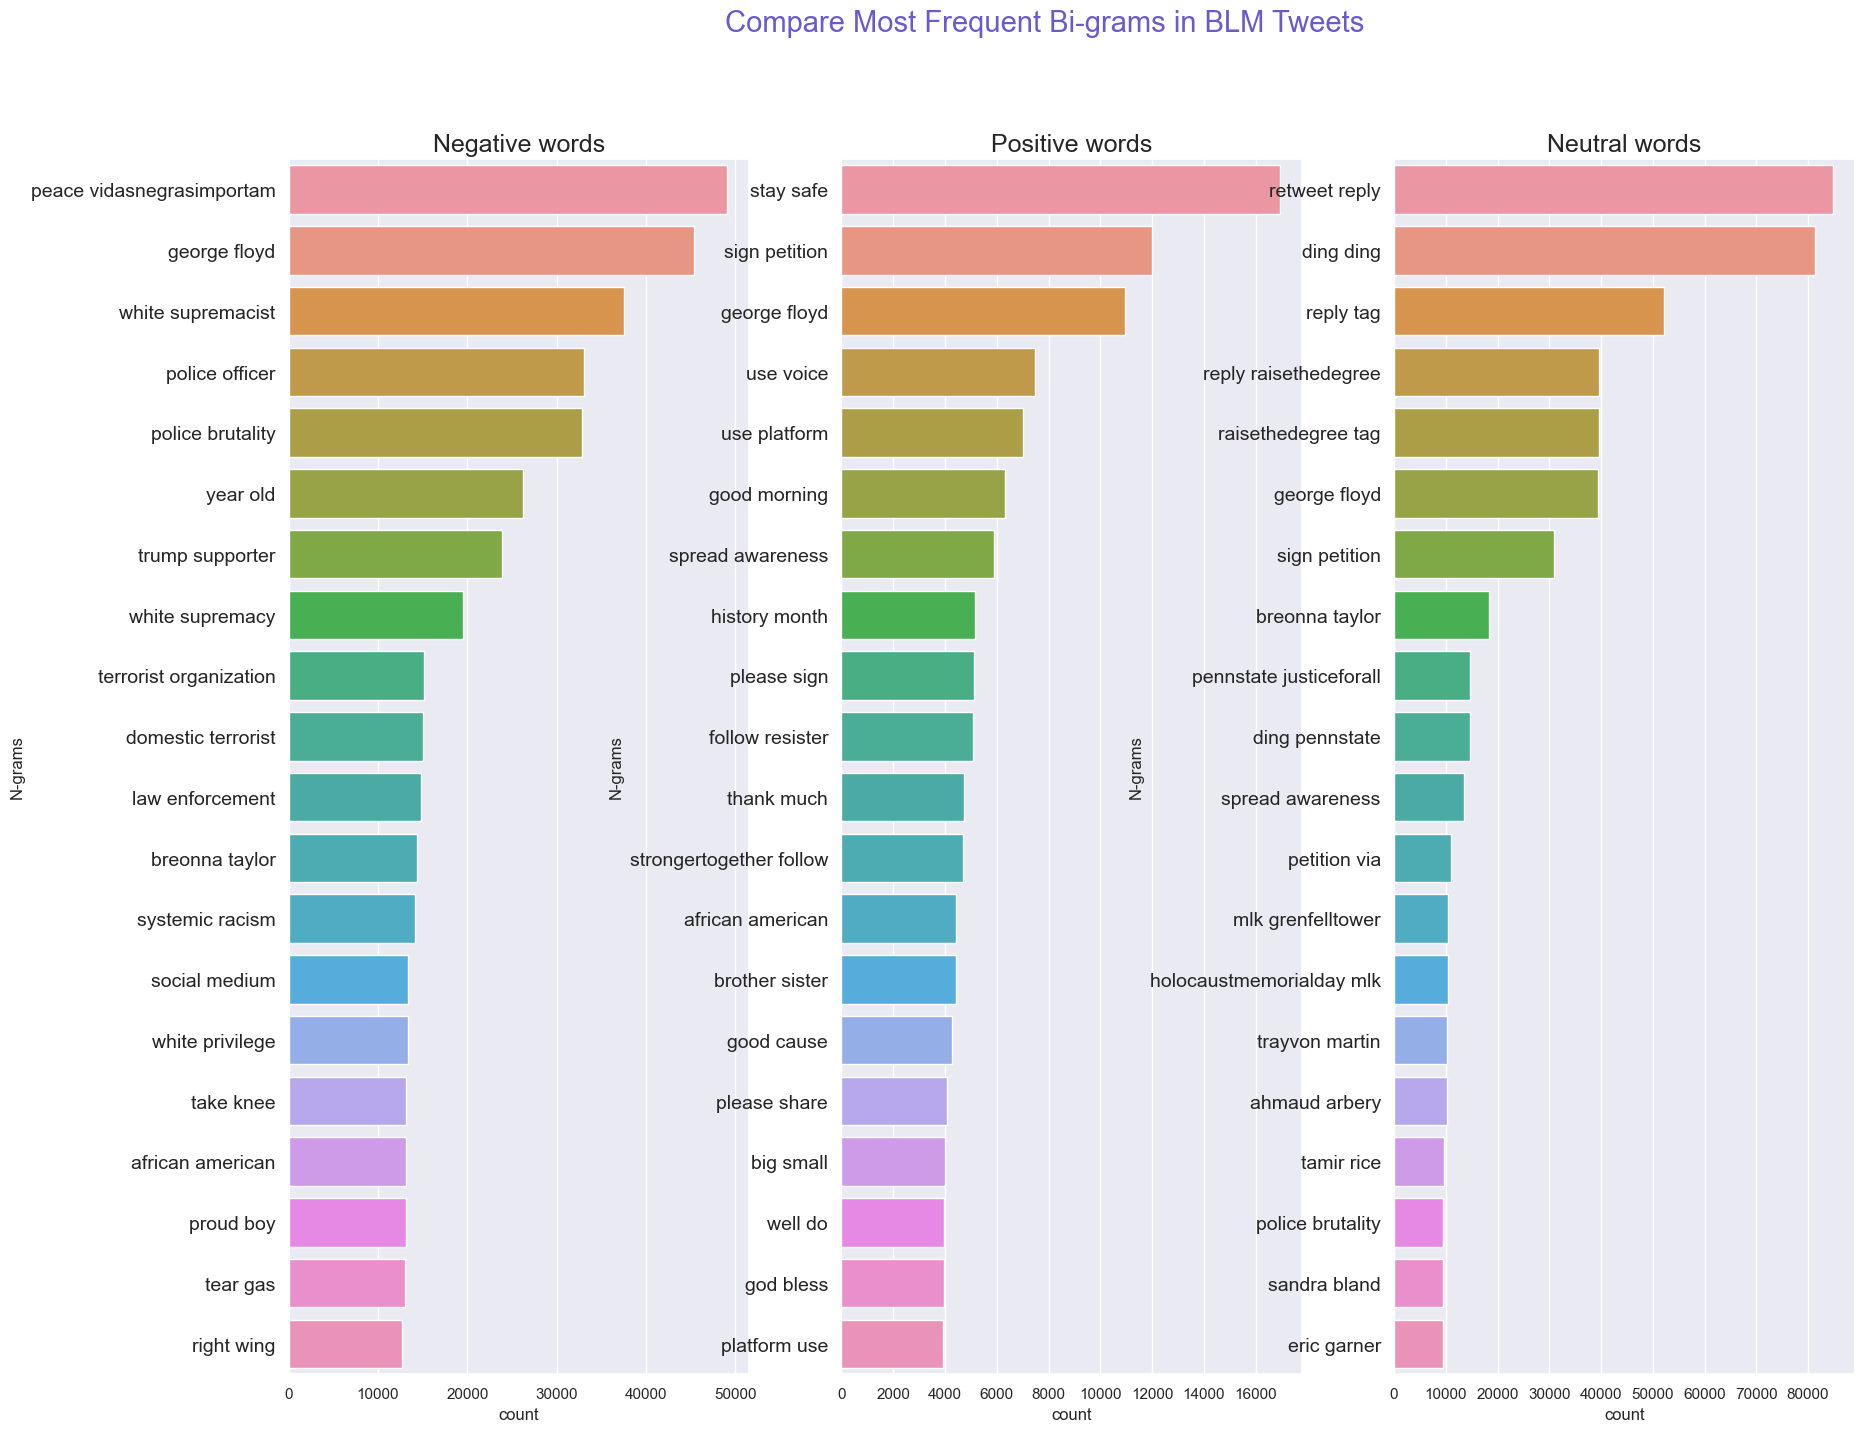

In [51]:
fig, axes = plt.subplots(1, 3)

fig.suptitle('Compare Most Frequent Bi-grams in BLM Tweets',
             size=21, color='SlateBlue')
axes[0].set_title('Negative words', size=18)
axes[1].set_title('Positive words', size=18)
axes[2].set_title('Neutral words', size=18)

plot_ngrams(ngrams_fn(df_copy, target_label='negative'), axes=axes[0])
plot_ngrams(ngrams_fn(df_copy, target_label='positive'), axes=axes[1])
plot_ngrams(ngrams_fn(df_copy, target_label='neutral'), axes=axes[2])
plt.show()

In [52]:
to_drop = [
    "ding ding",
    "retweet reply",
    "wear shirt"
    "reply tag",
    "ding pennstate",
    "oh wait",
    "oh yeah",
    "pride month",
    "link bio",
    "well ask",
    "sound like",
    "act like",
    "fbr",
    "tweetuk",
    "gt gt gt",
    "asian vet lgbtq",
    "voteblue follow follow",
    "indie dems"
]
df_copy = df_copy[
    ~df_copy["text_without_stopwords_freq"].str.contains("|".join(to_drop))
]

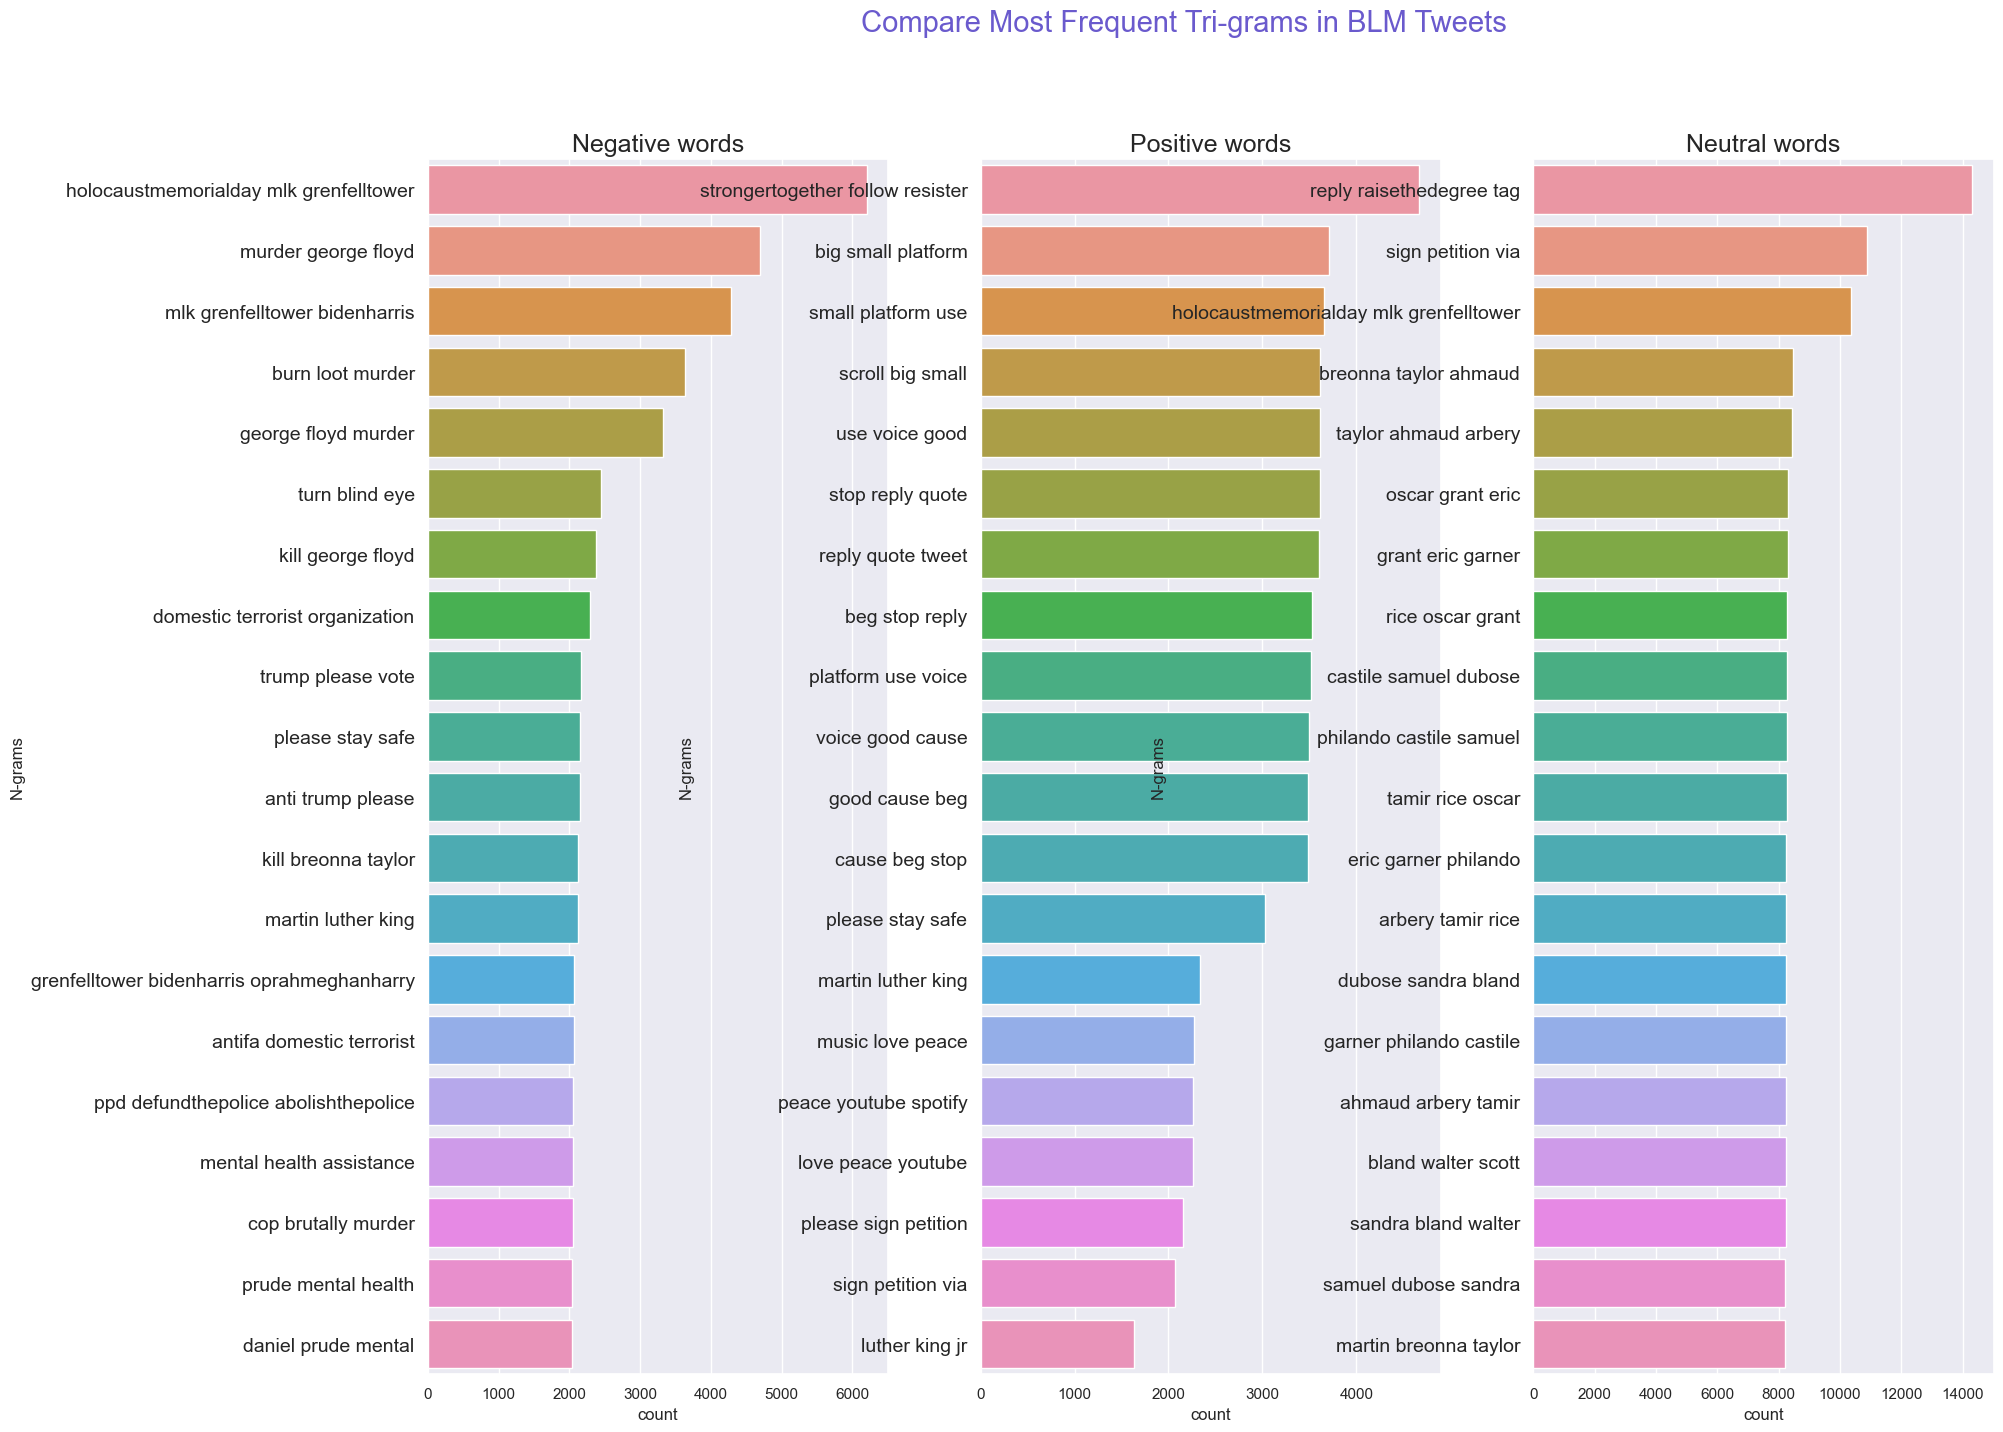

In [53]:
fig, axes = plt.subplots(1, 3)

fig.suptitle('Compare Most Frequent Tri-grams in BLM Tweets',
             size=21, color='SlateBlue')
axes[0].set_title('Negative words', size=18)
axes[1].set_title('Positive words', size=18)
axes[2].set_title('Neutral words', size=18)

plot_ngrams(ngrams_fn(df_copy, target_label='negative', n_grams=3), axes=axes[0])
plot_ngrams(ngrams_fn(df_copy, target_label='positive', n_grams=3), axes=axes[1])
plot_ngrams(ngrams_fn(df_copy, target_label='neutral', n_grams=3), axes=axes[2])
plt.show()

In [54]:
# Function to remove hashtags from a string
def remove_hashtags(text):
    return ' '.join(word for word in text.split() if not word.startswith('#'))

In [55]:
df_copy['no_hashtags'] = df_copy['cleanedContent'].apply(remove_hashtags)

In [56]:
df_copy['no_hashtags'] = df_copy['no_hashtags'].apply(clean_tweet)

In [57]:
df_copy['sentence_length'] = df_copy['no_hashtags'].str.len()

In [60]:
df_copy = df_copy[df_copy['sentence_length'] >= 50]

In [61]:
df_copy.columns

Index(['id', 'cleanedContent', 'label', 'category', 'emotion_label', 'text',
       'text_without_stopwords', 'text_lemmatized',
       'text_without_stopwords_freq', 'no_hashtags', 'sentence_length'],
      dtype='object')

In [62]:
df_copy.drop(columns=['no_hashtags', 'sentence_length'], inplace=True)

In [ ]:
df_copy.to_parquet("topic_modeling.parquet")